In [3]:
import math 
import time
import numpy as np
import torch
from d2l import torch as d2l

In [4]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [5]:
# 定义一个计时器
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        # 在init定义的函数相当于public了
        self.start()
    
    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times)/len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [6]:
c = torch.zeros(n)
# 实列化一个对象
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
# 建议学习
f'{timer.stop():.18f} sec'

'0.228049039840698242 sec'

In [7]:
timer.start()
d = a + b
f'{timer.stop():.18f} sec'

'0.000000000000000000 sec'

In [8]:
def normal(x, mu, sigma):
    p = 1/math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

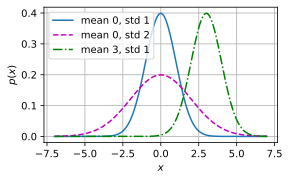

In [9]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='$x$', 
         ylabel='$p(x)$', figsize=(4.2, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [10]:
import random
import torch
from d2l import torch as d2l

In [11]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [12]:
true_w = torch.tensor([2, -3.4])
ture_b = 4.2
# featrues是X，而labels则是y
featrues, labels = synthetic_data(true_w, ture_b, 1000)

In [13]:
print('featues:', featrues[0], '\nlabel:', labels[0])

featues: tensor([-0.0165, -0.9486]) 
label: tensor([7.3836])


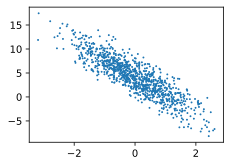

In [14]:
d2l.set_figsize()
d2l.plt.scatter(featrues[:,1].detach().numpy(), labels.detach().numpy(), 1)

In [15]:
# 读取数据集
def data_iter(batch_size, features, labels):
    num_examples = len(featrues)
    indices = list(range(num_examples))
    # 样本随机读取
    """
    return:在程序函数中返回某个值，返回之后函数不在继续执行，彻底结束。

    yield: 带有yield的函数是一个迭代器，函数返回某个值时，会停留在某个位置，
           返回函数值后，会在前面停留的位置继续执行，直到程序结束
    """
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield featrues[batch_indices], labels[batch_indices]

In [16]:
# 数据都是一行行的像个清单一样
batch_size = 10
for X, y in data_iter(batch_size, featrues, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4862, -0.2513],
        [ 0.9961, -2.0063],
        [ 0.4586,  1.3234],
        [ 0.3255,  0.6192],
        [ 0.1303, -1.4453],
        [-0.1585, -0.0719],
        [-0.6065, -1.0666],
        [-0.0884, -1.2134],
        [ 1.9479, -0.0057],
        [ 0.8251, -0.2271]]) 
 tensor([[ 6.0379],
        [13.0051],
        [ 0.6100],
        [ 2.7539],
        [ 9.3622],
        [ 4.1328],
        [ 6.6197],
        [ 8.1561],
        [ 8.0938],
        [ 6.6217]])


In [20]:
# 初始化模型参数
"""
b = torch.zeros(4, requires_grad=True)
b
tensor([0., 0., 0., 0.], requires_grad=True)
"""
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # w是求梯度的对象
b = torch.zeros(1, requires_grad=True)

In [21]:
# 定义模型
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [22]:
# 定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2

In [23]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    # with torch.no_grad():包起来的部分表示计算不会被跟踪梯度
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            # 清理计算过一次梯度后的梯度值
            param.grad.zero_()


In [36]:
# 训练
lr = 0.03
num_epochs = 3
# 1.a=f型属于将变量指向函数
# 2.a=f()型属于将f()的返回值赋值给a的过程
net = linreg
loss = squared_loss

In [40]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, featrues, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(featrues, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000097
epoch 2, loss 0.000096
epoch 3, loss 0.000096


In [41]:
# 测试集看一看效果
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {ture_b - b}')

w的估计误差: tensor([4.1497e-04, 6.2943e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0007], grad_fn=<RsubBackward1>)
